# Fig. 5: Phosphene alignment with the axon map

In [1]:
import os
import os.path as osp
import copy
import numpy as np
import pandas as pd
import numpy.random as npr

import pulse2percept as p2p
import argus_shapes as shapes

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


## Functions

In [2]:
def calc_implant_bundle_tangent(model, electrodes, name='orientation'):
    """Calculate NFB orientation nearest to an electrode
    
    For a list of electrodes, calculate the orientation of the
    nearest nerve fiber bundle.
    """
    return [model.calc_bundle_tangent(model.implant[e].x_center,
                                      model.implant[e].y_center)
            for e in electrodes]

In [3]:
def nullmodel1(model, electrodes, n_iter=10, random_state=42,
               r_range=(-np.pi/2, np.pi/2)):
    """A null model where each phosphene has a random orientation"""
    assert model._is_fitted
    npr.seed(random_state)
    return [npr.rand(len(electrodes)) * np.diff(r_range) + r_range[0]
            for _ in range(n_iter)]
    
    
def _nullmodel2_inner_loop(it, mmodel, electrodes, implant_type):
    xc, yc, rc = it
    model = copy.deepcopy(mmodel)
    model.implant = implant_type(x_center=xc, y_center=yc, rot=rc)
    return calc_implant_bundle_tangent(model, electrodes)

        
def nullmodel2(mmodel, electrodes, implant_type, n_iter=10, random_state=42,
               x_range=(-6000, 4000), y_range=(-4000, 4000),
               r_range=(-np.pi/2, np.pi/2)):
    """A null model where the implant is placed randomly on the retina """
    assert mmodel._is_fitted
    xc = npr.rand(n_iter) * np.diff(x_range) + x_range[0]
    yc = npr.rand(n_iter) * np.diff(y_range) + y_range[0]
    rc = npr.rand(n_iter) * np.diff(r_range) + r_range[0]

    return p2p.utils.parfor(_nullmodel2_inner_loop,
                            zip(xc, yc, rc),
                            func_args=[mmodel, electrodes, implant_type],
                            scheduler='multiprocessing')

In [4]:
def confint_1tailed(r_true, r_model, r_null, alpha=0.05, lo=0, hi=np.pi, verbose=False):
    """1-tailed confidence interval for axon map vs. null model"""
    n_iter = len(r_null)
    # Take the absolute error:
    a_model = np.abs(shapes.utils.angle_diff(r_true, r_model, lo=lo, hi=hi))
    a_model = np.where(a_model > hi/2, hi - a_model, a_model)
    
    # Null model: get `n_iter` estimates of the mean angular error:
    a_null = []
    for rn in r_null:
        # Absolute error, same as above:
        an = np.abs(shapes.utils.angle_diff(r_true, rn, lo=lo, hi=hi))
        an = np.where(an > hi/2, hi - an, an)
        a_null.append(np.mean(an))
        
    # Now look at the 1-tailed confidence interval:
    sorted_a_null = np.sort(np.array(a_null))
    if isinstance(alpha, (list, np.ndarray)):
        conf_int = np.array([sorted_a_null[int(a * n_iter)] for a in alpha])
    else:
        conf_int = sorted_a_null[int(alpha * n_iter)]
    if verbose:
        print('a_model:', np.mean(a_model))
        print('conf_int:', conf_int)
    return np.mean(a_model) < conf_int

In [5]:
def plot_orientation(subject, y_mean, subjectdata, ax, upside_down=True):
    """Plot simulated fundus image with phosphene orientations overlaid"""
    implant_type = subjectdata.loc[subject, 'implant_type']
    implant_rot = subjectdata.loc[subject, 'implant_rot']
    implant = implant_type(x_center=subjectdata.loc[subject, 'implant_x'], 
                           y_center=subjectdata.loc[subject, 'implant_y'],
                           rot=implant_rot, eye=subjectdata.loc[subject, 'eye'])
    loc_od = subjectdata.loc[subject, ['loc_od_x', 'loc_od_y']]
    p2p.viz.plot_fundus(implant, ax=ax, loc_od=loc_od, upside_down=upside_down)
    if isinstance(implant, p2p.implants.ArgusII):
        patch = patches.Rectangle((implant['A1'].x_center-400, implant['A1'].y_center-200),
                                  525*9+800, 525*5+800, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=3)
    else:
        patch = patches.Rectangle((implant['A1'].x_center-700, implant['A1'].y_center+300),
                                  900*4, 900*4, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=3)
    ax.add_patch(patch)
    for _, row in y_mean.iterrows():
        ax.quiver(implant[row['electrode']].x_center, implant[row['electrode']].y_center,
                  np.cos(row['orientation']), np.sin(row['orientation']), width=0.01,
                  color='w', zorder=100, headlength=0, headwidth=1, pivot='middle')
    ax.set_title(subject)
    # Remove annotations:
    for t in ax.texts:
        if 'temporal' in t.get_text() or 'nasal' in t.get_text():
            t.set_visible(False)
    # Plot scale bar:
    ax.plot([-5000, -5000 + shapes.utils.dva2ret(2)], [3500, 3500], 'w', linewidth=3)
    ax.text(-5000 + shapes.utils.dva2ret(2)/2, 3000, '2deg', ha='center', va='bottom', color='white')
    ax.set_xlim(-6000, 6000)
    if upside_down:
        ax.set_ylim(4000, -4000)
    else:
        ax.set_ylim(-4000, 4000)


def plot_drawing(ax, image, electrode=None, scale=1):
    """Plots a single phosphene drawing"""
    img_avg = shapes.imgproc.center_phosphene(image)
    img_avg = shapes.imgproc.scale_phosphene(img_avg, scale)
    ax.imshow(1 - img_avg, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if electrode is not None:
        a = ax.axis()
        ax.text(a[0], a[3], electrode, ha='left', va='top',
                bbox=dict(boxstyle='square,pad=0.5', fc='white', ec='black'))


def plot_insets(ax, Xy, electrodes, scale):
    """Plots example phosphene drawings as insets overlaid over the fundus image"""
    assert len(electrodes) == 3
    for electrode, loc in zip(electrodes, [1, 5, 4]):
        axins = inset_axes(ax, width='25%', height='25%', loc=loc)
        plot_drawing(axins, Xy[Xy.electrode == electrode].image.values[0], electrode, scale)

## Load data

In [6]:
# Assumes all data live in a directory ${DATA_ROOT}/argus_shapes, where DATA_ROOT is
# an environment variable. See README.md on GitHub.
# If no such environment variable exists, data will be automatically downloaded from
# OSF and stored in '../data/argus_shapes'
rootfolder = os.environ['DATA_ROOT'] if 'DATA_ROOT' in os.environ else osp.join('..', 'data')
datafolder = osp.join(rootfolder, 'argus_shapes')

In [7]:
# Load subject data:
subjectdata = shapes.load_subjects(osp.join(datafolder, 'subjects.csv'))
# A scaling factor is used when showing the drawings for the sake of visibility:
subjectdata['scale'] = pd.Series([2.5, 2.5, 2.5, 2.5], index=subjectdata.index)
subjects = subjectdata.index.sort_values()

In [8]:
# Load drawings:
Xy = shapes.load_data(osp.join(datafolder, 'drawings_single.csv'))

In [9]:
# Don't binarize (thresh=False), don't exclude inconsistent mean drawings (max_area=inf):
Xymu = shapes.calc_mean_images(Xy, thresh=False, max_area=np.inf)

## Plot

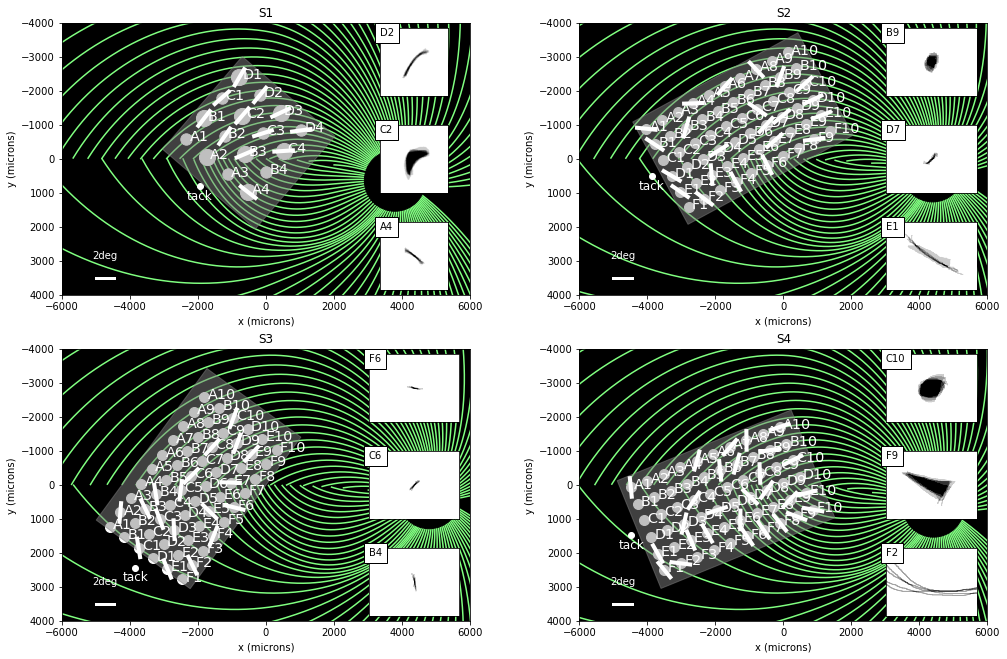

In [10]:
inset_electrodes = {
    'S1': ['D2', 'C2', 'A4'],
    'S2': ['B9', 'D7', 'E1'],
    'S3': ['F6', 'C6', 'B4'],
    'S4': ['C10', 'F9', 'F2']
}

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(17, 11))
for ax, subject in zip(axes.ravel(), subjects):
    plot_orientation(subject, Xymu[Xymu.subject == subject], subjectdata, ax)
    plot_insets(ax, Xymu[Xymu.subject == subject], inset_electrodes[subject], 
                subjectdata.loc[subject, 'scale'])
fig.savefig('fig5-axon-map-orientation.pdf', transparent=True)

## Resampling analysis

In [11]:
n_shuffle = 1000
alpha = [0.06, 0.05, 0.01, 0.001]

In [12]:
for subject in subjects:
    # Set up model:
    print(subject)
    print('- Fitting model...', end=' ')
    kwargs = subjectdata.drop(columns=['second_sight_id', 'scale']).loc[subject, :]
    model = shapes.models.AxonMapModel(engine='cython', xystep=10, **kwargs)
    model.fit(Xymu[Xymu.subject == subject])
    print('done.')
    
    electrodes = Xymu[Xymu.subject == subject].electrode
    print('- Calculating phosphene orientation...', end=' ')
    r_true = Xymu[Xymu.subject == subject].orientation
    print('done.')
    print('- Calculating model phosphene orientation...', end=' ')
    r_model = calc_implant_bundle_tangent(model, electrodes, name='r_model')
    print('done.')
    print('- Fraction of variance explained:', end=' ')
    fve = shapes.utils.circfve(r_true, r_model, lo=0, hi=np.pi)
    print(fve)
    print('- Null model 1: ', end=' ')
    r_null1 = nullmodel1(model, electrodes, n_iter=n_shuffle)
    is_signif1 = confint_1tailed(r_true, r_model, r_null1, alpha=alpha,
                                 lo=0, hi=np.pi)
    print(is_signif1)
    print('- Null model 2:', end=' ')
    r_null2 = nullmodel2(model, electrodes, subjectdata.loc[subject, 'implant_type'],
                         n_iter=n_shuffle)
    is_signif2 = confint_1tailed(r_true, r_model, r_null2, alpha=alpha,
                                 lo=0, hi=np.pi)
    print(is_signif2)

- Fitting model... done.
- Calculating phosphene orientation... done.
- Calculating model phosphene orientation... done.
- Fraction of variance explained: 0.462837756211
- Null model 1:  [ True  True  True  True]
- Null model 2: [ True False False False]
- Fitting model... done.
- Calculating phosphene orientation... done.
- Calculating model phosphene orientation... done.
- Fraction of variance explained: 0.567484300888
- Null model 1:  [ True  True  True False]
- Null model 2: [ True  True False False]
- Fitting model... done.
- Calculating phosphene orientation... done.
- Calculating model phosphene orientation... done.
- Fraction of variance explained: 0.0236766433652
- Null model 1:  [ True  True False False]
- Null model 2: [ True  True False False]
- Fitting model... done.
- Calculating phosphene orientation... done.
- Calculating model phosphene orientation... done.
- Fraction of variance explained: 0.393973496119
- Null model 1:  [ True  True  True False]
- Null model 2: [ Tru